# SSD (Single Shot Multibox Detector)
https://arxiv.org/pdf/1512.02325

In [1]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
DRIVE_ROOT = Path('/content/drive/MyDrive')

DATA_ROOT= Path('./data/')
MODEL_ROOT = DRIVE_ROOT / 'weights'

!mkdir -p {DATA_ROOT}
!mkdir -p {MODEL_ROOT}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install -q matplotlib
%pip install -q torchviz torchinfo
%pip install -q tqdm

In [3]:
from IPython.display import display

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary
from torchvision import datasets, models, ops, transforms

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

# Enable GPU device if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Download a backbone network's weight file.
if not (MODEL_ROOT/'vgg16_reducedfc.pth').exists():
    print('Downloading backbone network\'s weight file')
    !wget -q https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth -P {MODEL_ROOT}

## Dataset, Dataloader, Transformer
[PASCAL Visual Object Classes Challenge 2012 (VOC2012)](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html)

In [5]:
import PIL
from utils.ssd.augmentations import (
    Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand,
    RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans
)

class ImageTransform:
    def __init__(self, input_size, color_mean):
        self.transform = {
            'train': Compose([
                ConvertFromInts(),
                PhotometricDistort(),
                Expand(color_mean),
                RandomSampleCrop(),
                RandomMirror(),
                ToPercentCoords(),
                Resize(input_size),
                SubtractMeans(color_mean),
            ]),
            'val': Compose([
                ConvertFromInts(),
                ToPercentCoords(),
                Resize(input_size),
                SubtractMeans(color_mean),
            ]),
            'pred': Compose([
                ConvertFromInts(),
                Resize(input_size),
                SubtractMeans(color_mean),
            ]),
        }

    def __call__(self, image: PIL.Image, phase, boxes=None, labels=None):
        bgr_image = np.array(image)[:, :, (2, 1, 0)]
        bgr_image, boxes, labels = self.transform[phase](bgr_image, boxes, labels)
        rgb_image = bgr_image[:, :, (2, 1, 0)]  # BGR → RGB
        return rgb_image, boxes, labels


class AnnotationTransform:
    def __call__(self, annotation):
        target = []
        for region in annotation['annotation']['object']:
            name = region["name"]
            bbox = [int(region['bndbox'][key]) - 1 for key in ['xmin', 'ymin', 'xmax', 'ymax']]
            target.append((name, bbox))
        return target

In [6]:
class VOCDataset(Dataset):
    CLASSES = [
        "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
        "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
        "pottedplant", "sheep", "sofa", "train", "tvmonitor",
    ]
    CLASS_TO_INDEX = {
        class_name: index for index, class_name in enumerate(CLASSES)
    }
    CMAP = plt.cm.hsv(np.linspace(0, 1, len(CLASSES)))

    def __init__(self, root, phase, download=True, transform=None, target_transform=None):
        self.dataset = datasets.VOCDetection(root, year='2012', image_set=phase, download=download,
                                             target_transform=target_transform)
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.pull_item(idx)

    def pull_item(self, idx):
        # Get inputs.
        image, annotation = self.dataset[idx]
        width, height = image.size

        # Create boxes and labels from annotation.
        boxes = []
        labels = []
        for name, region in annotation:
            boxes.append(region)
            labels.append(self.CLASS_TO_INDEX[name])
        boxes, labels = np.array(boxes, dtype=np.float64), np.array(labels)

        # Transform image, boxes, and labels.
        if self.transform:
            image, boxes, labels = self.transform(image, self.phase, boxes, labels)
        target = np.hstack((boxes, labels.reshape(-1, 1)))

        # Return as TorchTensor.
        image = transforms.ToTensor()(image)
        target = torch.FloatTensor(target)
        return image, target

    def get_original_image(self, idx):
        return self.dataset[idx][0]


def collate_fn(batch):
    images = []
    targets = []
    for image, target in batch:
        images.append(image)
        targets.append(target)
    images = torch.stack(images, dim=0)

    return images, targets

In [7]:
INPUT_SIZE = 300
COLOR_MEAN = (104, 117, 123)
BATCH_SIZE = 64
download = True

train_dataset = VOCDataset(root=DATA_ROOT, phase='train', download=download,
                           transform=ImageTransform(INPUT_SIZE, COLOR_MEAN),
                           target_transform=AnnotationTransform())
val_dataset = VOCDataset(root=DATA_ROOT, phase='val', download=download,
                         transform=ImageTransform(INPUT_SIZE, COLOR_MEAN),
                         target_transform=AnnotationTransform())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=collate_fn, num_workers=2)

dataloaders = {'train': train_loader, 'val': val_loader}

## Network Models

In [8]:
def init_weights(model):
    '''He-Initialization'''
    if isinstance(model, nn.Conv2d):
        nn.init.kaiming_normal_(model.weight.data)
        if model.bias is not None:
            nn.init.constant_(model.bias.data, 0.0)

In [9]:
def make_vgg(weights=None):
    features = models.vgg16().features[:-1]
    _, _, pool3_idx, pool4_idx = (i for i, layer in enumerate(features) if isinstance(layer, nn.MaxPool2d))
    features[pool3_idx].ceil_mode = True

    vgg = nn.Sequential(
        *features,
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),            # pool5
        nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6),  # fc6
        nn.ReLU(inplace=True),
        nn.Conv2d(1024, 1024, kernel_size=1),                        # fc7
        nn.ReLU(inplace=True),
    )

    if weights:
        vgg.load_state_dict(weights)
    else:
        vgg.apply(init_weights)
    return nn.ModuleList([vgg[:pool4_idx], vgg[pool4_idx:]])


make_vgg()

ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
def make_extras():
    return nn.ModuleList([
        nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=1),                      # conv8_1
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # conv8_2
            nn.ReLU(inplace=True),
        ),
        nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1),                       # conv9_1
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # conv9_2
            nn.ReLU(inplace=True),
        ),
        nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1),                       # conv10_1
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # conv10_2
            nn.ReLU(inplace=True),
        ),
        nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1),                       # conv11_1
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3),                       # conv11_2
            nn.ReLU(inplace=True),
        ),
    ])


make_extras()

ModuleList(
  (0): Sequential(
    (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (3): Sequential(
    (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
)

In [11]:
def make_regressors_classifiers(num_classes, num_anchors_list):
    reg_layers = []
    cls_layers = []

    in_channels = [512, 1024, 512, 256, 256, 256]
    for in_channel, num_anchors in zip(in_channels, num_anchors_list):
        # Apply conv-layer for sourceX.
        reg_layers += [nn.Conv2d(in_channel, 4 * num_anchors, kernel_size=3, padding=1)]
        cls_layers += [nn.Conv2d(in_channel, num_classes * num_anchors, kernel_size=3, padding=1)]

    # Size(loc):  [N,           4 * num_anchors, H, W]
    # Size(conf): [N, num_classes * num_anchors, H, W].
    return nn.ModuleList(reg_layers), nn.ModuleList(cls_layers)


make_regressors_classifiers(21, [4, 6, 6, 6, 4, 4])

(ModuleList(
   (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (4-5): 2 x Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ),
 ModuleList(
   (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (4-5): 2 x Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ))

In [12]:
class L2Norm(nn.Module):
    def __init__(self, in_channels=512, scale=20):
        super(L2Norm, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(in_channels))
        nn.init.constant_(self.weights, scale)
        self.eps = 1e-10

    def forward(self, x):
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt() + self.eps  # Size([N, 1, 38, 38])
        x = x / norm

        # Size([512]) -> Size([N, 512, 38, 38]).
        weights = self.weights.view(1, -1, 1, 1).expand_as(x)
        return x * weights

In [13]:
from itertools import product

def make_dboxes(config):
    image_size = config['image_size']
    feature_map_sizes = config['feature_map_sizes']
    steps = config['lr_steps']
    min_sizes = config['dbox_min_sizes']
    max_sizes = config['dbox_max_sizes']
    aspect_ratios = config['dbox_aspect_ratios']

    dboxes = []
    # 'feature_map_sizes': [38, 19, 10, 5, 3, 1] (source1~source6)
    for k, f in enumerate(feature_map_sizes):
        # Loop for grid (x, y) in [0, 1, .., f-1] x [0, 1, .., f-1].
        for y, x in product(range(f), repeat=2):
            # The center point of DBox in normalized corrdinate (0-1).
            f_k = image_size / steps[k]
            cx = (x + 0.5) / f_k
            cy = (y + 0.5) / f_k

            # Small square Dbox.
            s_k = min_sizes[k] / image_size
            dboxes.append([cx, cy, s_k, s_k])

            # Large square Dbox.
            s_k_prime = math.sqrt(s_k * (max_sizes[k] / image_size))
            dboxes.append([cx, cy, s_k_prime, s_k_prime])

            # Aspect ratio DBoxes.
            for ratio in aspect_ratios[k]:
                dboxes.append([cx, cy, s_k * np.sqrt(ratio), s_k / np.sqrt(ratio)])
                dboxes.append([cx, cy, s_k / np.sqrt(ratio), s_k * np.sqrt(ratio)])

    output = torch.Tensor(dboxes).view(-1, 4)  # Size([8732, 4])
    return output.clamp(min=0, max=1)

In [14]:
class SSD(nn.Module):
    def __init__(self, config, vgg_weights=None):
        super(SSD, self).__init__()
        self.num_classes = config['num_classes']
        self.num_anchors = config['num_anchors']

        # SSD Network components.
        self.vgg = make_vgg(vgg_weights)
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.regressors, self.classifiers = make_regressors_classifiers(
            self.num_classes, self.num_anchors)

        # Default boxes.
        self.dboxes = make_dboxes(config)

    def forward(self, x: torch.Tensor):
        sources = []

        # Foward through the backbone network.
        x = self.vgg[0](x)
        source1 = self.L2Norm(x)
        sources.append(source1)

        x = self.vgg[1](x)
        sources.append(x)

        # Loop for source3 - source6.
        for layer in self.extras:
            x = layer(x)
            sources.append(x)

        loc_list = []
        conf_list = []
        for source, box_regressor, classifier in zip(sources, self.regressors, self.classifiers):
            l = box_regressor(source)
            c = classifier(source)

            # Permute torch.Tensor from (N, KA, H, W) to (N, H*W*KA)
            # s.t. K: (loc) 4, (conf) num_classes, A: num_anchors.
            N = l.size(0)
            l = l.permute(0, 2, 3, 1).contiguous().view(N, -1)
            c = c.permute(0, 2, 3, 1).contiguous().view(N, -1)

            loc_list.append(l)
            conf_list.append(c)

        # Concat all results.
        loc = torch.cat(loc_list, dim=1)
        conf = torch.cat(conf_list, dim=1)

        # Resize [N, -1, K]
        N = loc.size(0)
        loc = loc.view(N, -1, 4)
        conf = conf.view(N, -1, self.num_classes)
        return loc, conf, self.dboxes

In [15]:
SSD_CONFIG = {
    'image_size': 300,
    'num_classes': 21,  # background + 20 classes.
    'num_anchors': [4, 6, 6, 6, 4, 4],           # Anchors for each source.
    'feature_map_sizes': [38, 19, 10, 5, 3, 1],  # Image size for each source.
    'lr_steps': [8, 16, 32, 64, 100, 300],
    'dbox_min_sizes': [30, 60, 111, 162, 213, 264],
    'dbox_max_sizes': [60, 111, 162, 213, 264, 315],
    'dbox_aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

vgg_weights = torch.load(MODEL_ROOT/'vgg16_reducedfc.pth', weights_only=False)
model = SSD(SSD_CONFIG, vgg_weights)

## Loss Function

In [16]:
import torch.nn.functional as F

from utils.ssd.box_utils import match, decode, nms

class MultiBoxLoss(nn.Module):
    def __init__(self, iou_threshold=0.5, neg_pos_ratio=3, variance = [0.1, 0.2], device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.iou_threshold = iou_threshold
        self.neg_pos_ratio = neg_pos_ratio  # Neg:Pos ratio in Hard Negative Mining
        self.variance = variance # Variance for (x,y) and (w,h).
        self.device = device

    def forward(self, loc, conf, dboxes, targets):
        # loc: Size([N, 8732, 4]), conf: Size([N, 8732, 21]), dboxes: Size([8732, 4]).
        N, num_dboxes, _ = loc.size()
        num_classes = conf.size(2)

        # Make ground truths (loc_t, conf_t) using input defeault boxes and annotation bboxes.
        loc_t = torch.Tensor(N, num_dboxes, 4).to(self.device)
        conf_t = torch.LongTensor(N, num_dboxes).to(self.device)
        dboxes = dboxes.to(self.device)
        for i in range(N):
            bboxes = targets[i][:, :4].to(self.device)
            labels = targets[i][:, -1].to(self.device)
            match(self.iou_threshold, bboxes, dboxes, self.variance, labels, loc_t, conf_t, i)

        # ----------------
        # Calculate L_loc.
        # ----------------
        pos_mask = conf_t > 0
        pos_ids = pos_mask.unsqueeze(2).expand_as(loc)

        loc_p = loc[pos_ids].view(-1, 4)    # Size([8732, 4])
        loc_t = loc_t[pos_ids].view(-1, 4)  # Size([8732, 4])

        # Compute loss by Smooth L1 loss with loc_p and loc_t.
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # ----------------
        # Calculate L_conf.
        # ----------------

        # Compute loss by Cross Entropy loss at once.
        loss_c = s_c = F.cross_entropy(
            conf.view(-1, num_classes),
            conf_t.view(-1),
            reduction='none'
        )

        loss_c = loss_c.view(N, -1)  # Size([N*8732]) -> Size([N, 8732])
        loss_c[pos_mask] = 0  # Set loss: 0 for positive boxes.

        # Suppress negative boxes by Hard Negative Mining.
        num_pos = pos_mask.long().sum(1, keepdim=True)                      # Size([N, 1])
        num_neg = torch.clamp(num_pos * self.neg_pos_ratio, max=num_dboxes) # Size([N, 1])

        _, loss_ids = loss_c.sort(1, descending=True)
        _, idx_rank = loss_ids.sort(1)
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        pos_ids = pos_mask.unsqueeze(2).expand_as(conf)
        neg_ids = neg_mask.unsqueeze(2).expand_as(conf)

        conf_hnm = conf[(pos_ids+neg_ids).gt(0)].view(-1, num_classes)
        conf_hnm_t = conf_t[(pos_mask+neg_mask).gt(0)]
        loss_c = F.cross_entropy(conf_hnm, conf_hnm_t, reduction='sum')

        num_boxes = num_pos.sum()
        return loss_l/num_boxes, loss_c/num_boxes

## Train, Validate, and Predict

In [17]:
def train(model, criterion, optimizer, data_loader, device):
    model.train()

    n_batch = 0
    total_loss = 0
    with tqdm(data_loader, desc='Train', leave=False) as pbar:
        for images, targets in pbar:
            n_batch += 1

            images = images.to(device)
            targets = [t.to(device) for t in targets]
            optimizer.zero_grad()

            loc, conf, anchor_boxes = model(images)
            loss_l, loss_c = criterion(loc, conf, anchor_boxes, targets)
            loss = loss_l + loss_c

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({'train_loss': loss.item()})
    return total_loss / n_batch

@torch.no_grad()
def validate(model, criterion, data_loader, device):
    model.eval()

    n_batch = 0
    total_loss = 0
    with tqdm(data_loader, desc='Validate', leave=False) as pbar:
        for images, targets in pbar:
            n_batch += 1

            images = images.to(device)
            targets = [t.to(device) for t in targets]

            loc, conf, anchor_boxes = model(images)
            loss_l, loss_c = criterion(loc, conf, anchor_boxes, targets)
            loss = loss_l + loss_c

            total_loss += loss.item()
            pbar.set_postfix({'val_loss': loss.item()})
    return total_loss / n_batch

def train_and_validate(num_epochs, model, criterion, optimizer, dataloaders, device):
    model = model.to(device)
    torch.backends.cudnn.benchmark = True

    for epoch in range(num_epochs):
        train_loss = train(model, criterion, optimizer, dataloaders['train'], device)
        print(f'Epoch [{epoch+1}/{num_epochs}], train loss: {train_loss:.5f}')

        if ((epoch+1) % 10 == 0):
            # Validation.
            val_loss = validate(model, criterion, dataloaders['val'], device)
            print(f'val loss: {val_loss:.5f}')

            # Save weights to a pth-file.
            pth_filepath = MODEL_ROOT / f'ssd300_{epoch+1}.pth'
            print(f'Save the weights in {pth_filepath}')
            torch.save(model.state_dict(), pth_filepath)

In [18]:
num_epochs = 80

model = SSD(SSD_CONFIG, vgg_weights)
model = model.to(device)

criterion = MultiBoxLoss(iou_threshold=0.5, neg_pos_ratio=3, device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

train_and_validate(num_epochs, model, criterion, optimizer, dataloaders, device)

Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [1/80], train loss: 14.65522


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [2/80], train loss: 9.06420


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [3/80], train loss: 7.19266


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [4/80], train loss: 6.70034


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [5/80], train loss: 6.44729


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [6/80], train loss: 6.26467


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [7/80], train loss: 6.05638


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [8/80], train loss: 5.91227


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [9/80], train loss: 5.81244


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [10/80], train loss: 5.67920


Validate:   0%|          | 0/91 [00:00<?, ?it/s]

val loss: 5.72172
Save the weights in /content/drive/MyDrive/weights/ssd300_10.pth


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [11/80], train loss: 5.54274


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [12/80], train loss: 5.50301


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [13/80], train loss: 5.37739


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [14/80], train loss: 5.28544


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [15/80], train loss: 5.21602


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [16/80], train loss: 5.11823


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [17/80], train loss: 5.05957


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [18/80], train loss: 4.99712


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [19/80], train loss: 4.93744


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [20/80], train loss: 4.87490


Validate:   0%|          | 0/91 [00:00<?, ?it/s]

val loss: 4.95628
Save the weights in /content/drive/MyDrive/weights/ssd300_20.pth


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [21/80], train loss: 4.81280


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [22/80], train loss: 4.73962


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [23/80], train loss: 4.70931


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [24/80], train loss: 4.65548


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [25/80], train loss: 4.60833


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [26/80], train loss: 4.55833


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [27/80], train loss: 4.51393


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [28/80], train loss: 4.48952


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [29/80], train loss: 4.41972


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [30/80], train loss: 4.35324


Validate:   0%|          | 0/91 [00:00<?, ?it/s]

val loss: 4.52893
Save the weights in /content/drive/MyDrive/weights/ssd300_30.pth


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [31/80], train loss: 4.33667


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [32/80], train loss: 4.33177


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [33/80], train loss: 4.27753


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [34/80], train loss: 4.29820


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [35/80], train loss: 4.22811


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [36/80], train loss: 4.16981


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [37/80], train loss: 4.11617


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [38/80], train loss: 4.10667


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [39/80], train loss: 4.08500


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [40/80], train loss: 4.08287


Validate:   0%|          | 0/91 [00:00<?, ?it/s]

val loss: 4.29095
Save the weights in /content/drive/MyDrive/weights/ssd300_40.pth


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [41/80], train loss: 4.02758


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [42/80], train loss: 4.00362


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [43/80], train loss: 3.97797


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [44/80], train loss: 3.93898


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [45/80], train loss: 3.92837


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [46/80], train loss: 3.90670


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [47/80], train loss: 3.88104


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [48/80], train loss: 3.85532


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [49/80], train loss: 3.89142


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [50/80], train loss: 3.80620


Validate:   0%|          | 0/91 [00:00<?, ?it/s]

val loss: 4.15544
Save the weights in /content/drive/MyDrive/weights/ssd300_50.pth


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [51/80], train loss: 3.75410


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [52/80], train loss: 3.75974


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [53/80], train loss: 3.77407


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [54/80], train loss: 3.75489


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [55/80], train loss: 3.70879


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [56/80], train loss: 3.66042


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [57/80], train loss: 3.67535


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [58/80], train loss: 3.69393


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [59/80], train loss: 3.62979


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [60/80], train loss: 3.66677


Validate:   0%|          | 0/91 [00:00<?, ?it/s]

val loss: 4.02398
Save the weights in /content/drive/MyDrive/weights/ssd300_60.pth


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [61/80], train loss: 3.59627


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [62/80], train loss: 3.59071


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [63/80], train loss: 3.56918


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [64/80], train loss: 3.54077


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [65/80], train loss: 3.54777


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [66/80], train loss: 3.52823


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [67/80], train loss: 3.50970


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [68/80], train loss: 3.49510


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [69/80], train loss: 3.48978


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [70/80], train loss: 3.46871


Validate:   0%|          | 0/91 [00:00<?, ?it/s]

val loss: 4.00657
Save the weights in /content/drive/MyDrive/weights/ssd300_70.pth


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [71/80], train loss: 3.45955


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [72/80], train loss: 3.44457


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [73/80], train loss: 3.44808


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [74/80], train loss: 3.42210


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [75/80], train loss: 3.39035


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [76/80], train loss: 3.38621


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [77/80], train loss: 3.41034


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [78/80], train loss: 3.36495


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [79/80], train loss: 3.34008


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [80/80], train loss: 3.34611


Validate:   0%|          | 0/91 [00:00<?, ?it/s]

val loss: 3.95187
Save the weights in /content/drive/MyDrive/weights/ssd300_80.pth


## Inference

In [18]:
# num_epochs = 80
model = SSD(SSD_CONFIG, vgg_weights).to(device)
model.load_state_dict(torch.load(MODEL_ROOT/f'ssd300_{num_epochs}.pth', weights_only=False))

<All keys matched successfully>

In [19]:
def decode_bboxes(loc, dboxes):
    # Calculate bounding boxes from loc and dboxes (cx+dx, cy+dy, w+dw, h+dh).
    # Size([8732, 4]).
    boxes = torch.cat((
        dboxes[:, :2] + loc[:, :2] * 0.1 * dboxes[:, 2:],
        dboxes[:, 2:] * torch.exp(loc[:, 2:] * 0.2)), dim=1)

    # [cx, cy, w, h] -> [xmin, xmax, ymin, ymax].
    boxes[:, :2] -= boxes[:, 2:] / 2
    boxes[:, 2:] += boxes[:, :2]
    return boxes

In [20]:
class Detector():
    def __init__(self, ssd_model, top_k=200, conf_threshold=0.6, nms_threshold=0.45, transform=None):
        self.ssd_model = ssd_model.to('cpu')
        self.top_k = top_k
        self.conf_threshold = conf_threshold
        self.nms_threshold = nms_threshold
        self.transform = transform
        self.softmax = nn.Softmax(dim=-1)

    @torch.no_grad()
    def __call__(self, image: PIL.Image):
        width, height = image.size

        # Pre-Process the input image.
        if self.transform:
            x, _, _ = self.transform(image, 'pred')
        x = transforms.ToTensor()(x) # Size([C, H, W])
        x = x.unsqueeze(0)           # Size([1, C, H, W])

        # Forward the network and post-process to create detection results.
        # Size([1, num_classes, top_k, 5 (score, xmin, ymin, xmax, ymax)])
        detections = self.detect(x)
        detections = detections.cpu().detach().numpy()

        # Filter by conf_threshold.
        # mask[0]: batch_idx, mask[1]: class_idx, mask[2]: bbox_idx.
        mask = np.where(detections[:, 0:, :, 0] > self.conf_threshold)
        detections = detections[mask]

        results = []
        for detection, label in zip(detections, mask[1]):
            if label == 0:
                continue
            score = detection[0]
            bbox = detection[1:] * [width, height, width, height]
            results.append((label-1, score, bbox))
        return results

    def detect(self, x):
        self.ssd_model.eval()
        loc, conf, dboxes = self.ssd_model(x)

        N, num_dboxes, _ = loc.size()
        num_classes = conf.size(2)

        conf = self.softmax(conf)
        conf = conf.transpose(1, 2) # [1, 8732, num_classes] -> [1, num_classes, 8732].

        output = torch.zeros(N, num_classes, self.top_k, 5)
        for i in range(N):
            # Decode bounding boxes by loc and dboxes.
            decoded_boxes = decode_bboxes(loc[i], dboxes)

            # Main process.(Since 0 means background, use 1~num_classes)
            for cl in range(1, num_classes):
                c_mask = conf[i][cl] > 0
                scores = conf[i][cl][c_mask]
                if scores.nelement() == 0:
                    continue

                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)  # Size([8732, 4])
                bboxes = decoded_boxes[l_mask].view(-1, 4)             # Size([8732, 4])

                # Non-maximum suppression.
                ids = ops.nms(decoded_boxes, scores, self.nms_threshold)
                count = min(self.top_k, ids.size(0))

                output[i, cl, :count] = torch.cat(
                    (scores[ids[:count]].unsqueeze(1), bboxes[ids[:count]]),
                    dim=1
                )
        return output

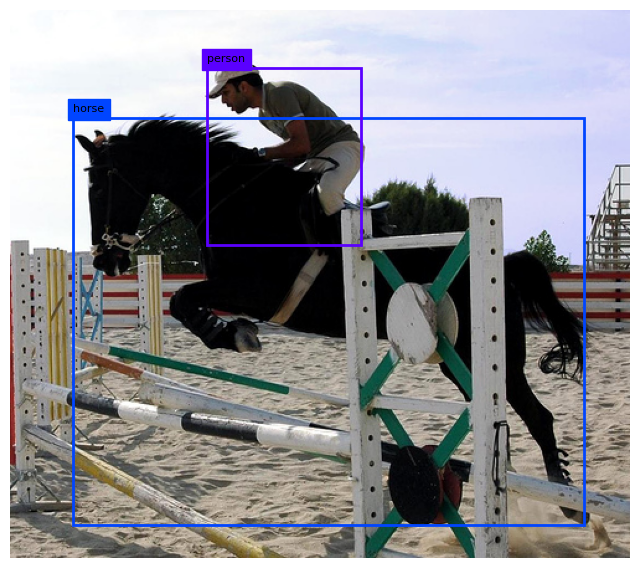

In [21]:
def draw_target(ax, label, bbox):
    xmin, ymin, xmax, ymax = bbox
    color = VOCDataset.CMAP[label]
    name = VOCDataset.CLASSES[label]
    ax.text(xmin, ymin - 5, name, color='black', fontsize=8, backgroundcolor=color)
    rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor=color, facecolor='none', linewidth=2)
    ax.add_patch(rect)
    return ax


image = train_dataset.get_original_image(0)
detector = Detector(model, transform=ImageTransform(INPUT_SIZE, COLOR_MEAN))
results = detector(image)

plt.figure(figsize=(8,8))
plt.axis('off')
plt.grid('off')
ax = plt.gca()
ax.imshow(image)
for label, sc, bbox in results:
    draw_target(ax, label, bbox)